DDPM : Denoising Diffusion Probabilistic Models

- Ref: 
    - DDPM: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Denoising_Diffusion_Probabilistic_Models




In [7]:
import os
import torch
import torch.nn as nn
import numpy as np

import math
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torchshow as ts

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision.transforms.functional as F
from pathlib import Path

import time


In [8]:
## Unet network model
# Ref: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Denoising_Diffusion_Probabilistic_Models/unet.py

def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bohw', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x


- DDPM
    - ![DDPM](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FRXOe5%2Fbtru2nyl2SU%2FzkLx0SMgf1qpaI01kCmGu1%2Fimg.png)

In [9]:
# Diffusion Model

class DiffusionModel:

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # DPM_SOLVER
        self.alphas = torch.sqrt(self.alpha_bar)
        self.sigmas = torch.sqrt(1.0 - self.alpha_bar)
        self.lambdas = torch.log(self.alphas / self.sigmas)

    def training(self, x0, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """

        # x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                          dtype=torch.long)
        eps = torch.randn_like(x0)

        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), sample_it = 10):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """
        t_lst = []
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        for it in tqdm(range(self.T, 0, -1), desc="Sampling"):
            if it % sample_it == 0:
                t_lst.append((it, x))
            z = torch.randn_like(x) if it > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * it

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        t_lst.append((it-1, x))
        return x, t_lst

    @torch.no_grad()
    def ddpm_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """

        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x
        # for t in progress_bar(range(self.T, 0, -1)):
        for t in tqdm(range(self.T, 0, -1), desc="DDPM Sampling"):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        return x

    @torch.no_grad()
    def ddim_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                      n_steps=50, use_tqdm=True):

        step_size = self.T // n_steps
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x

        # for i in progress_bar(range(n_steps)):
        for i in tqdm(range(n_steps), desc="DDIM Sampling"):
            t = self.T - i * step_size
            t_tensor = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_prev = self.alpha_bar[t - step_size - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) if t > step_size else torch.tensor(1.0).to(self.device)

            # Predicted noise
            eps_pred = self.function_approximator(x, t_tensor - 1)

            # Predicted x_0
            x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_pred) / torch.sqrt(alpha_bar_t)

            # Direction pointing to xt
            dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps_pred

            # Update rule
            x = torch.sqrt(alpha_bar_prev) * x0_pred + dir_xt

        return x

    @torch.no_grad()
    def dpm_solver_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), n_steps=10, use_tqdm=True):
        """
        DPM-Solver-2 (Algorithm 1 from https://arxiv.org/pdf/2206.00927).
        """
        step_size = self.T // n_steps
        # start from Gaussian noise x_T
        xT = torch.randn((n_samples, image_channels, img_size[0], img_size[1]), device=self.device)
        x_tilde = xT

        for i in tqdm(range(n_steps), desc="DPM-Solver Sampling", disable=not use_tqdm):

            t_prev = self.T - i * step_size
            t_cur = max(t_prev - step_size, 1)

            # midpoint in λ-space
            lam_mid = (self.lambdas[t_prev - 1] + self.lambdas[t_cur - 1]) / 2.
            # invert λ→t via nearest neighbor lookup
            s_i = torch.argmin(torch.abs(self.lambdas - lam_mid)).item() + 1

            # λ-step size
            h = self.lambdas[t_cur - 1] - self.lambdas[t_prev - 1]

            # model evaluation at t_prev
            t_prev_tensor = torch.full((n_samples,), t_prev, dtype=torch.long, device=self.device)
            u_i = (self.alphas[s_i - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[s_i - 1] * (
                torch.exp(h * 0.5) - 1) * self.function_approximator(x_tilde, t_prev_tensor - 1)

            t_s_tensor = torch.full((n_samples,), s_i, dtype=torch.long, device=self.device)
            x_tilde = (self.alphas[t_cur - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[t_cur - 1] * (
                torch.exp(h) - 1) * self.function_approximator(u_i, t_s_tensor - 1)

        return x_tilde

In [10]:
if torch.backends.mps.is_available():
    g_device = torch.device("mps")
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    g_device = torch.device("cuda")
else:
    g_device = torch.device("cpu")
print(g_device)

Current memory allocated on MPS: 1261548544 bytes
Driver memory allocated on MPS: 4675682304 bytes
mps


In [11]:

def save_video(img_t_lst, nrows = 9, ncols = 9, v_fp = "test.mp4"):
    # fig, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    fig, axes = plt.subplots(nrows, ncols)
    ims = []
    for i, imt in img_t_lst:
        frame_ims = []
        if not isinstance(i, int):
            i = i[0]
        for j, ax in enumerate(axes.flat):
            # print(f"{i}_{j}")
            # ax.set_title(f"{i}_{j}")
            ax.axis('off')
            frame_ims.append(ax.imshow(F.to_pil_image(imt[j].to("cpu").clip(0, 1)), cmap='gray'))
        ims.append(frame_ims)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    # vfp = os.path.join(g_video_path, v_fname)
    ani.save(v_fp, writer="ffmpeg", fps=10)

Epoch - 0


Sampling: 100%|██████████| 1000/1000 [00:31<00:00, 31.89it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/00_Diffusion_MNIST_videos/test_000.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 32.95it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.351086854934692 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 31.61it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5837092399597168 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.7336869239807129 seconds
Epoch - 1


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.25it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.07491374015808 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.61it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.535423994064331 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.59it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6049671173095703 seconds
Epoch - 2


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.96it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.451302766799927 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.75it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4408531188964844 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6246180534362793 seconds
Epoch - 3


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.22it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.10436201095581 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.97it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.474034070968628 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5991301536560059 seconds
Epoch - 4


DDPM Sampling: 100%|██████████| 1000/1000 [00:33<00:00, 29.43it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 33.980712890625 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 31.18it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.606083869934082 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6303431987762451 seconds
Epoch - 5


Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.08it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/00_Diffusion_MNIST_videos/test_005.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.59it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.77159023284912 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.70it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5313851833343506 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6152408123016357 seconds
Epoch - 6


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.39it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.94819712638855 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.03it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.519853115081787 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6158251762390137 seconds
Epoch - 7


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.27it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.060360193252563 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.01it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5167722702026367 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6152868270874023 seconds
Epoch - 8


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 32.71it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.574770212173462 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.83it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5251431465148926 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.598095178604126 seconds
Epoch - 9


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.13it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.18818497657776 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.86it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.523475170135498 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6090250015258789 seconds
Epoch - 10


Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.07it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/00_Diffusion_MNIST_videos/test_010.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 32.79it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.500556707382202 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 31.87it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5707449913024902 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.38it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6125030517578125 seconds
Epoch - 11


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.97it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.443103075027466 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.96it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4743578433990479 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.85it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5963389873504639 seconds
Epoch - 12


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.05it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.370324850082397 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.00it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5166959762573242 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5906078815460205 seconds
Epoch - 13


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.87138605117798 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.92it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4759180545806885 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6232740879058838 seconds
Epoch - 14


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.65it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.715895891189575 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.29it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5037100315093994 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.53it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6069180965423584 seconds
Epoch - 15


Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.88it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/00_Diffusion_MNIST_videos/test_015.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.00it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.41701602935791 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.42it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4980478286743164 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.592609167098999 seconds
Epoch - 16


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.78it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.60595989227295 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.18it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4645888805389404 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6319718360900879 seconds
Epoch - 17


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.73it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.646540880203247 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.16it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4659428596496582 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.43it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6105949878692627 seconds
Epoch - 18


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.21it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.232287883758545 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.93it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4756479263305664 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.34it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6138401031494141 seconds
Epoch - 19


Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.52it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/00_Diffusion_MNIST_videos/test_019.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.65it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.72340989112854 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.97it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5184590816497803 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.50it/s]
/Users/hyunjae.k/anaconda3/envs/cv_playgrounds/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6081600189208984 seconds


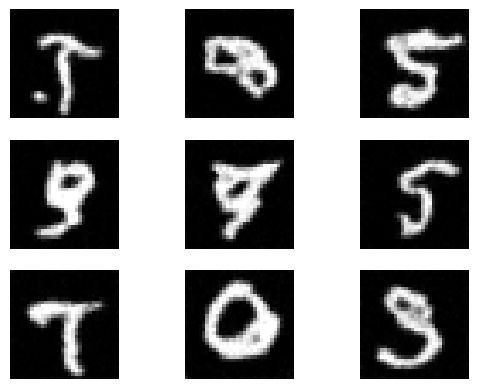

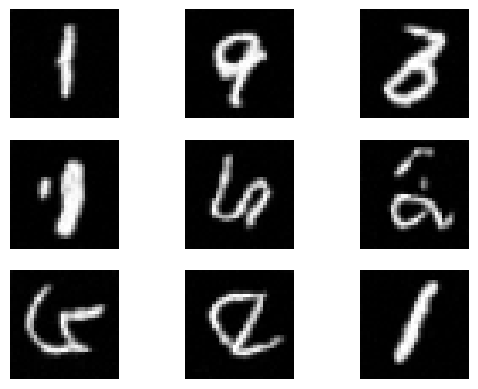

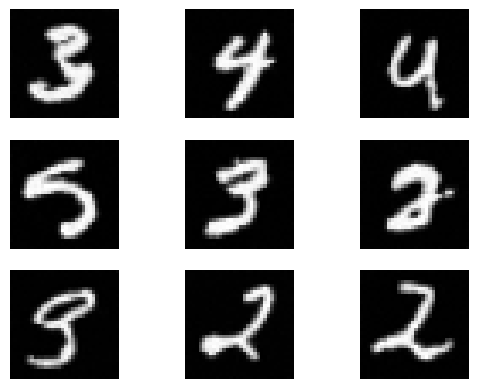

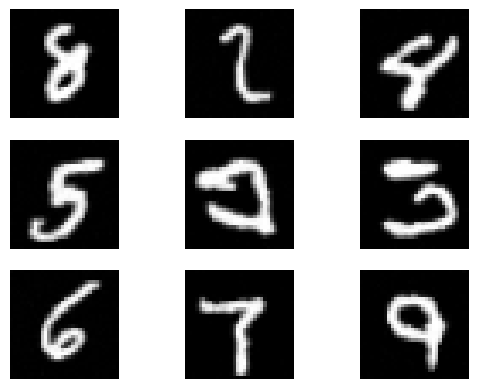

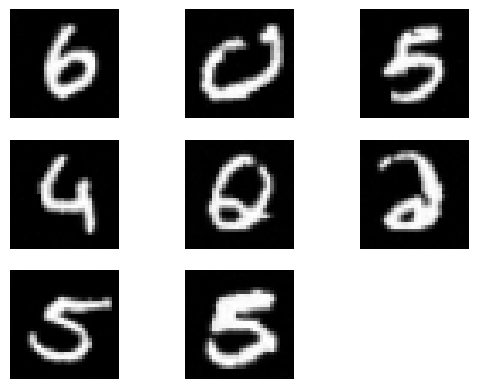

In [12]:
g_model_path = './temp/00_Diffusion_MNIST_models/'
g_video_path = './temp/00_Diffusion_MNIST_videos/'
Path(g_model_path).mkdir(exist_ok=True, parents=True)
Path(g_video_path).mkdir(exist_ok=True, parents=True)


# parameters
batch_size = 32
epoches = 20
nb_images = 9
img_channel = 1

# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32),interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
            ])
dataset = datasets.MNIST(root='./temp/data', train=True, download=True, transform=transform)
len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Setup Model
model = UNet(in_ch = img_channel)
model.to(g_device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, g_device)

# Training
loss_lst = []
for ep in range(epoches):
    print(f"Epoch - {ep}")
    tq = tqdm(enumerate(dataloader), total = len(dataloader), desc="Training")
    for i, x0, in tq:
        x0 = x0[0].to(g_device)
        _loss = diffusion_model.training(x0, batch_size, optimizer)
        loss_lst.append(_loss)
        tq.set_description(f"Loss: {_loss:.5f}; step {i}; epoch {ep}")

    _model_path = os.path.join(g_model_path, f'unet_{ep:03d}.pth')
    torch.save(diffusion_model.function_approximator.state_dict(), _model_path)

    diffusion_model.function_approximator.eval()
    if ep % 5 == 0 or ep == epoches-1:
        _, t_list = diffusion_model.sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32))
        vfp = os.path.join(g_video_path, f"test_{ep:03d}.mp4")
        save_video(t_list, 3, 3, vfp)


    st = time.time()
    samples = diffusion_model.ddpm_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DDPM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.ddim_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DDIM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddim_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.dpm_solver_sampling(n_samples=nb_images, n_steps=10, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DPM-Solver-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"dpm_solver_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)


    diffusion_model.function_approximator.train()

plt.plot(loss_lst)
plt.show()

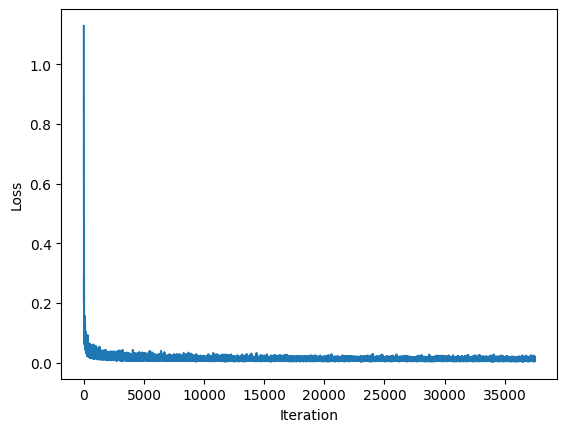

In [13]:
# plot losses
plt.plot(loss_lst)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()